In [ ]:
#!pip install git+https://github.com/nerfstudio-project/gsplat.git

: 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from gsplat.rendering import rasterization
import math
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda'

In [2]:
# Optionally use the context manager to ensure one of the fused kernels is run
query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device=device)
key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device=device)
value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device=device)


In [3]:
with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=True):
    F.scaled_dot_product_attention(query,key,value)

In [34]:
class FlowModel(nn.Module):

    def forward(self, X, time):
        raise NotImplementedError()
    

class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        emb = self.freqs * t[..., None]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class FlowNeuralNetwork(FlowModel):

    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features)


    def forward(self, X, time):
        X = torch.cat([X, self.time_embedding(time)], axis=1)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

In [43]:
width = 256
height = 256
n_gaussians = 100
num_cams = 1
means = torch.rand((n_gaussians, 3), device=device)
quats = torch.rand((n_gaussians, 4), device=device)
quats = quats / torch.linalg.norm(quats, dim=1, keepdim=True)
scales = torch.rand((n_gaussians, 3), device=device)
colors = torch.rand((n_gaussians, 3), device=device)
opacities = torch.ones((n_gaussians,), device=device)
camtoworlds = torch.tensor(
            [
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -3.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            ],
            device=device,
        )
fov_x = math.pi / 2.0
focal = 0.5 * float(width) / math.tan(0.5 * fov_x)
Ks = torch.tensor(
            [
                [focal, 0, width / 2],
                [0, focal, height / 2],
                [0, 0, 1],
            ],
            device=device,
        )

Ks = Ks[None].repeat(num_cams, 1, 1)

colors.requires_grad = True
means.requires_grad = True
scales.requires_grad = True
quats.requires_grad = True
optimizer = torch.optim.Adam(
            [colors, means, scales, opacities, quats], 0.01
        )


In [44]:
img = np.array(Image.open('/home/ubuntu/gsplats-expr/abstr.jpeg').resize((256, 256)))

In [45]:
img_t = torch.tensor(img / 255)[None].to(device)

In [46]:
render_colors, render_alphas, info = rasterization(
            means=means,
            quats=quats,
            scales=scales,
            opacities=opacities,
            colors=colors,
            viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
            Ks=Ks,  # [C, 3, 3]
            width=width,
            height=height,
            packed=False,
            absgrad=True,
            sparse_grad=False,
            rasterize_mode="antialiased",
        )

In [47]:
max_steps = 20000
renders = []

for step_id in range(max_steps):
    optimizer.zero_grad()
    render_colors, render_alphas, info = rasterization(
                means=means,
                quats=quats / torch.linalg.norm(quats, dim=1, keepdim=True),
                scales=scales,
                opacities=opacities,
                colors=colors,
                viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
                Ks=Ks,  # [C, 3, 3]
                width=width,
                height=height,
                packed=False,
                absgrad=True,
                sparse_grad=False,
                rasterize_mode="antialiased",
            )
    renders.append(render_colors[0])
    loss = torch.nn.MSELoss()(render_colors.float(), img_t.float())

    loss.backward()
    optimizer.step()
    # if step_id % 500 == 0:
    #     print(loss.item())

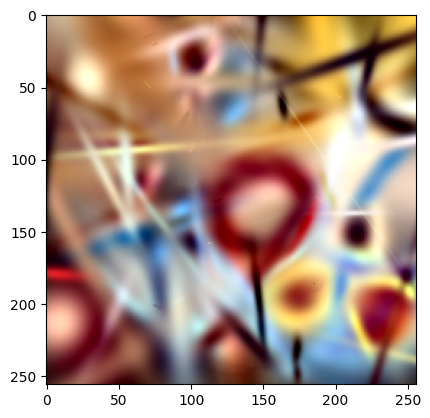

In [48]:
plt.imshow((torch.clamp(render_colors[0], 0, 1).cpu().data.numpy() * 255).astype(np.uint8))

In [49]:
colors.shape, means.shape, scales.shape, quats.shape

(torch.Size([100, 3]),
 torch.Size([100, 3]),
 torch.Size([100, 3]),
 torch.Size([100, 4]))

In [50]:
torch.cat([colors, means, scales, quats], dim=-1).shape

torch.Size([100, 13])

In [51]:
def conditional_flow_matching_loss(flow_model, x):
    sigma_min = 1e-4
    t = torch.rand(x.shape[0], device=x.device)
    noise = torch.randn_like(x)

    x_t = (1 - (1 - sigma_min) * t[:, None]) * noise + t[:, None] * x
    optimal_flow = x - (1 - sigma_min) * noise
    predicted_flow = flow_model(x_t, time=t)

    return (predicted_flow - optimal_flow).square().mean()

model = FlowNeuralNetwork(n_features=3, n_blocks=5, time_embedding_size=8).cuda().train()
optimizer = torch.optim.AdamW(model.parameters())
target = means.clone() #torch.cat([colors, means, scales, quats], dim=-1)

for epoch in range(30_000):
    model.zero_grad()
    loss = conditional_flow_matching_loss(model, target)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(epoch, loss.item())

model = model.eval()

0 4.044599533081055
500 2.3098132610321045
1000 2.427828073501587
1500 2.433640956878662
2000 2.6733977794647217
2500 2.2252838611602783
3000 2.649930238723755
3500 2.5746586322784424
4000 2.4027650356292725
4500 2.786860942840576
5000 2.3114447593688965
5500 2.3186445236206055
6000 2.791048765182495
6500 2.4918320178985596
7000 2.174301862716675
7500 2.6464591026306152
8000 2.2529280185699463
8500 2.3413569927215576
9000 2.2729594707489014
9500 2.3200643062591553
10000 2.4821510314941406
10500 2.5005757808685303
11000 2.448892831802368
11500 2.39426589012146
12000 2.389008045196533
12500 2.4476513862609863
13000 2.3073642253875732
13500 2.3174171447753906
14000 2.507985830307007
14500 2.2433996200561523
15000 2.385199785232544
15500 2.498344898223877
16000 2.379558801651001
16500 2.235785722732544
17000 2.419386148452759
17500 1.885077714920044
18000 2.2288899421691895
18500 2.2427005767822266
19000 2.131915330886841
19500 2.588545560836792
20000 2.153245449066162
20500 2.084566593170

In [52]:
from zuko.utils import odeint

@torch.no_grad()
def run_flow(flow_model, x_0, t_0, t_1, device='cpu'):
    def f(t: float, x):
        return flow_model(x, time=torch.full(x.shape[:1], t, device=device))

    return odeint(f, x_0, t_0, t_1, phi=flow_model.parameters())

In [53]:
noise = torch.randn_like(target)
out = run_flow(model.cuda(), noise.cuda(), 0, 1, device='cuda')

In [39]:
#colors_pred, means_pred, scales_pred, quats_pred = out[:, :3], out[:, 3:6], out[:, 6:9], out[:, 9:]
means_pred = out.clone()

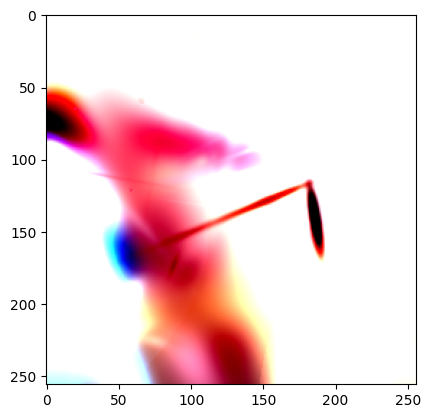

In [54]:
render_colors, render_alphas, info = rasterization(
            means=means_pred,
            quats=quats,
            scales=scales,
            opacities=opacities,
            colors=colors,
            viewmats=torch.linalg.inv(camtoworlds),  # [C, 4, 4]
            Ks=Ks,  # [C, 3, 3]
            width=width,
            height=height,
            packed=False,
            absgrad=True,
            sparse_grad=False,
            rasterize_mode="antialiased",
        )

plt.imshow((torch.clamp(render_colors[0], 0, 1).cpu().data.numpy() * 255).astype(np.uint8))